In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!rm -rf '/content/Tomato-plant-village'

In [3]:
!unzip '/content/drive/MyDrive/DATASET/Tomato-plant-village.zip' -d '/content/Tomato-plant-village'

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/Tomato-plant-village/train/Target_Spot/824cf247-344d-446f-9f9c-09d24a0da04c___Com.G_TgS_FL 9735.JPG  
  inflating: /content/Tomato-plant-village/train/Target_Spot/8284cba7-30b7-401d-923d-65f7786d7aae___Com.G_TgS_FL 8333.JPG  
  inflating: /content/Tomato-plant-village/train/Target_Spot/82ba214d-1cf1-4c69-a7f2-4630a9071396___Com.G_TgS_FL 8306.JPG  
  inflating: /content/Tomato-plant-village/train/Target_Spot/82bd3282-8841-4d56-96fb-46047fb86001___Com.G_TgS_FL 0647.JPG  
  inflating: /content/Tomato-plant-village/train/Target_Spot/83012967-2bcc-4af2-bd6c-c26b329fdb55___Com.G_TgS_FL 7966.JPG  
  inflating: /content/Tomato-plant-village/train/Target_Spot/8313b39e-fbf5-466f-b5ca-5830e0b06d73___Com.G_TgS_FL 7865.JPG  
  inflating: /content/Tomato-plant-village/train/Target_Spot/831b4c22-17fe-4241-8515-998650421d31___Com.G_TgS_FL 9876.JPG  
  inflating: /content/Tomato-plant-village/train/Target_Spot/832b624f-9979-

In [4]:
!ls '/content/Tomato-plant-village/test'

Bacterial_spot	Late_blight   Septoria_leaf_spot  Yellow_Leaf_Curl_Virus
Early_blight	Leaf_Mold     Spider_mites
Healthy		Mosaic_virus  Target_Spot


In [5]:
!ls '/content/Tomato-plant-village/train'

Bacterial_spot	Late_blight   Septoria_leaf_spot  Yellow_Leaf_Curl_Virus
Early_blight	Leaf_Mold     Spider_mites
Healthy		Mosaic_virus  Target_Spot


In [6]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print('All modules have been imported')

All modules have been imported


In [7]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



In [8]:
def plot_label_count (df, column):
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()
    values=vcounts.tolist()
    plt.figure(figsize=(20,5))
    form = {'family': 'serif', 'color': 'blue', 'size': 25}
    plt.bar(labels, values)
    plt.title('Images per label', fontsize= 24, color='blue')
    plt.xticks(rotation=90, fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel("Labels", fontdict=form)
    plt.ylabel('Number of Images', fontdict=form)
    plt.show()

In [9]:
def make_dataframes(train_dir,test_dir, val_dir):
    bad_images=[]
    if test_dir == None and val_dir==None:
        dirlist=[train_dir]
        names = ['train']
    elif test_dir == None:
        dirlist=[train_dir,  val_dir]
        names=['train', 'valid']
    elif val_dir == None:
        dirlist=[train_dir,  test_dir]
        names=['train', 'test']
    else:
        dirlist=[train_dir, test_dir, val_dir]
        names=['train','test', 'valid']
    zipdir=zip(names, dirlist)
    for name,d in zipdir:
        filepaths=[]
        labels=[]
        classlist=sorted(os.listdir(d) )
        for klass in classlist:
            classpath=os.path.join(d, klass)
            flist=sorted(os.listdir(classpath))
            desc=f'{name:6s}-{klass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                try:
                    img=cv2.imread(fpath)
                    shape=img.shape
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    bad_images.append(fpath)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1)
        if name =='valid':
            valid_df=df
        elif name == 'test':
            test_df=df
        else:
            if test_dir == None and val_dir == None:
                pdf=df
                train_df, dummy_df=train_test_split(pdf, train_size=.5, shuffle=True, random_state=12, stratify=pdf['labels'])
                valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=12, stratify=dummy_df['labels'])
            elif test_dir == None:
                pdf=df
                train_df,test_df=train_test_split(pdf, train_size=.5, shuffle=True, random_state=12, stratify=pdf['labels'])
            else : # create a  validation dataframe
                pdf=df
                train_df = df;
                #train_df,valid_df=train_test_split(pdf, train_size=.75, shuffle=True, random_state=12, stratify=pdf['labels'])
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=1, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)
    counts=list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    if len(bad_images) == 0:
        print_in_color('All image files were properly processed and used in the dataframes')
    else:
        print_in_color('Below is a list of defective image files')
        for f in bad_images:
            print (f)
    return train_df, test_df, valid_df, classes, class_count
 # if there is no test directory set test_dir = None, a test_df dataframe will be created from train_df
test_dir = r'/content/Tomato-plant-village/test'
 # if there is no validation directory set val_dir = None, a valid_df dataframe will be created from train_df
val_dir=  r'/content/Tomato-plant-village/test' #None
train_dir= r'/content/Tomato-plant-village/train'

train_df, test_df, valid_df, classes, class_count=make_dataframes(train_dir,test_dir, val_dir)

valid -Yellow_Leaf_Curl_Virus   : 100%|██████████████████████████████████████████████████| 1071/1071 [00:00<00:00, 2368.33files/s]

number of classes in processed dataset=  10
the maximum files in any class in train_df is  4286   the minimum files in any class in train_df is  299
train_df length:  14532   test_df length:  3628   valid_df length:  3628
average image height=  256   average image width=  256  aspect ratio h/w=  1.0
All image files were properly processed and used in the dataframes



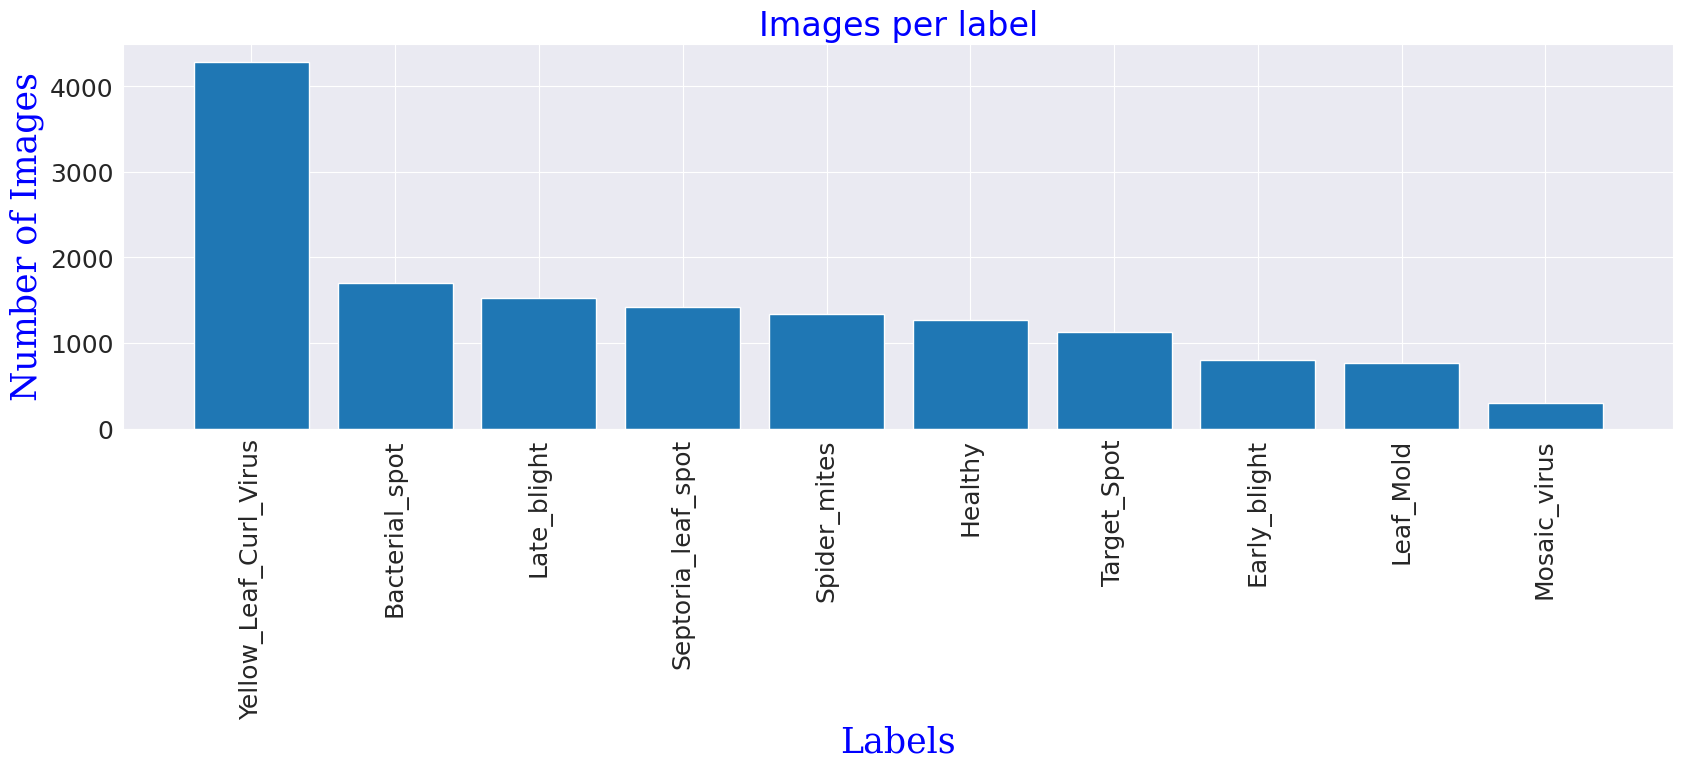

In [10]:
if len(train_df['labels'].unique())<20: # Over 20 labels the plot is to hard to understand
    plot_label_count (train_df, 'labels')

In [11]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=400
min_samples=400
column='labels'
#train_df, classes, class_count = trim(train_df, max_samples, min_samples, column)

In [ ]:
def balance(df, n,column, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))

    # n=100
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df[column].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    
    # ✅ CẢI TIẾN: Tăng cường Data Augmentation để model tổng quát hóa tốt hơn
    gen = ImageDataGenerator(
        horizontal_flip=True,           # Lật ngang
        vertical_flip=True,             # Lật dọc
        rotation_range=30,              # Xoay ±30 độ
        width_shift_range=0.2,          # Dịch ngang 20%
        height_shift_range=0.2,         # Dịch dọc 20%
        zoom_range=0.3,                 # Zoom 30%
        shear_range=0.2,                # Biến dạng 20%
        brightness_range=[0.7, 1.3],    # Thay đổi độ sáng
        fill_mode='nearest'             # Lấp đầy pixel gần nhất
    )

    groups=df.groupby(column) # group by class
    for label in df[column].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='bmp')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=sorted(os.listdir(classpath))
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n=300
column='labels'
working_dir=r'./'
img_size=(300,300)
train_df=balance(train_df, n,column, working_dir, img_size)

Initial length of dataframe is  14532
Found 299 validated image filenames.
Total Augmented images created=  1
Length of augmented dataframe is now  14533


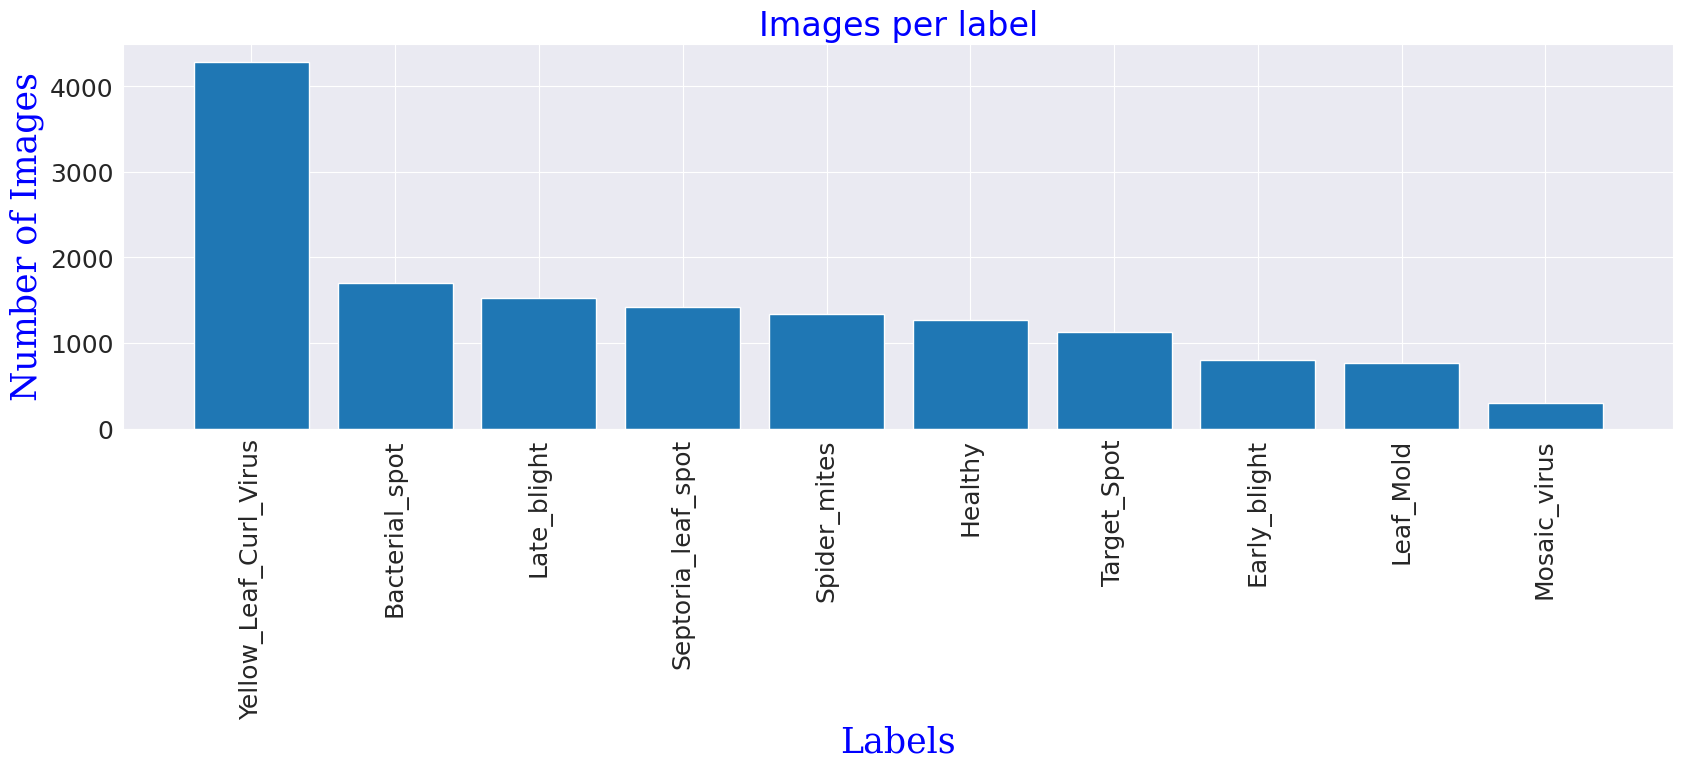

In [13]:
# Show train_df images per label after balancing the dataset
plot_label_count(train_df, 'labels')

In [ ]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    # ✅ CẢI TIẾN: Tăng augmentation cho training để giảm overfitting
    trgen=ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.2,
        brightness_range=[0.8, 1.2]
    )
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps

In [15]:
batch_size=20
ycol='labels'
train_gen, test_gen, valid_gen, test_steps= make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size)

Found 14533 validated image filenames belonging to 10 classes.
Found 3628 validated image filenames belonging to 10 classes.
Found 3628 validated image filenames belonging to 10 classes.
test batch size:  4   test steps:  907  number of classes :  10


In [16]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

Output hidden; open in https://colab.research.google.com to view.

In [17]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Reshape, multiply,
    BatchNormalization, Dropout, Conv2D, Activation, Add,
    GlobalMaxPooling2D, Concatenate # Import Concatenate
)
from tensorflow.keras import Model, regularizers
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import backend as K

# -----------------------------
# Squeeze-and-Excitation (SE) Block
# -----------------------------
class SEBlock(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super(SEBlock, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio
        self.global_avg_pool = GlobalAveragePooling2D()
        self.dense1 = Dense(units=None, activation='relu')
        self.dense2 = Dense(units=None, activation='sigmoid')
        self.reshape_layer = Reshape([1, 1, None]) # Renamed to avoid conflict
        self.multiply_layer = multiply # Renamed to avoid conflict

    def build(self, input_shape):
        channels = input_shape[-1]
        self.dense1.units = channels // self.reduction_ratio
        self.dense2.units = channels
        self.reshape_layer.target_shape = [1, 1, channels]
        super(SEBlock, self).build(input_shape)

    def call(self, input_tensor):
        se = self.global_avg_pool(input_tensor)
        se = self.dense1(se)
        se = self.dense2(se)
        se = self.reshape_layer(se)
        scaled_tensor = self.multiply_layer([input_tensor, se])
        return scaled_tensor

# -----------------------------
# Coordinate Attention Module (CA)
# -----------------------------
class CABlock(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super(CABlock, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        if channels is None:
            raise ValueError("Channel dimension must be known for CABlock to build its layers.")

        # Shared Dense layer (acts on the last dimension, i.e., channels)
        self.shared_dense = Dense(channels // self.reduction_ratio, activation='relu', name='ca_shared_dense')

        # Separate Dense layers for output (these also act on the last dimension)
        self.h_output_dense = Dense(channels, activation='sigmoid', name='ca_h_output_dense')
        self.w_output_dense = Dense(channels, activation='sigmoid', name='ca_w_output_dense')

        super(CABlock, self).build(input_shape)

    def call(self, input_tensor):
        # input_tensor shape: (batch, H, W, C)
        # Dynamically get spatial dimensions
        h_spatial = tf.shape(input_tensor)[1]
        w_spatial = tf.shape(input_tensor)[2]
        # channels will be known after build, but can also be accessed dynamically
        channels = input_tensor.shape[-1]

        # 1. Global average pooling along width to get height-wise context
        avg_pool_h = tf.reduce_mean(input_tensor, axis=2, keepdims=True) # Output shape: (B, H, 1, C)

        # 2. Global average pooling along height to get width-wise context
        avg_pool_w = tf.reduce_mean(input_tensor, axis=1, keepdims=True) # Output shape: (B, 1, W, C)

        # Apply the shared dense layer to transform features
        # This will operate on the channel dimension (last dimension)
        h_mlp = self.shared_dense(avg_pool_h) # Output shape: (B, H, 1, C // reduction_ratio)
        w_mlp = self.shared_dense(avg_pool_w) # Output shape: (B, 1, W, C // reduction_ratio)

        # Apply separate dense layers to get attention weights for H and W
        h_attention = self.h_output_dense(h_mlp) # Output shape: (B, H, 1, C)
        w_attention = self.w_output_dense(w_mlp) # Output shape: (B, 1, W, C)

        # Combine attention with input tensor using element-wise multiplication and addition
        output_tensor = tf.multiply(input_tensor, h_attention) + tf.multiply(input_tensor, w_attention)

        return output_tensor

# -----------------------------
# Model Builder: EfficientNetB4 + SE + CA
# -----------------------------
def make_model_with_2se_ca(img_size, lr, class_count):
    img_shape = (img_size[0], img_size[1], 3)

    # Load EfficientNetB4 backbone
    base_model = tf.keras.applications.efficientnet.EfficientNetB4(
        include_top=False, weights="imagenet", input_shape=img_shape
    )
    base_model.trainable = True  # Fine-tuning enabled

    x = base_model.output  # Feature maps from EfficientNetB4

    # Apply SE block
    se_block = SEBlock(reduction_ratio=16)
    x = se_block(x)

    # Apply CA block
    ca_block = CABlock(reduction_ratio=16)
    x = ca_block(x)

    # Classification head
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)

    x = Dense(
        256,
        kernel_regularizer=regularizers.l2(0.001),
        activity_regularizer=regularizers.l1(0.0012),
        activation='relu'
    )(x)
    # ✅ CẢI TIẾN: Tăng Dropout từ 0.4 lên 0.5 để giảm overfitting
    x=Dropout(rate=.5, seed=123)(x)
    # Final output
    output = Dense(class_count, activation='softmax')(x)

    # Compile model
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adamax(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', F1_score, tf.keras.metrics.AUC(name='auc')]) # Add AUC metric

    print(f"EfficientNetB4 model with SE + CA blocks, lr={lr}, Dropout=0.5")
    return model


# -----------------------------
# Example usage
# -----------------------------
img_size = (300, 300)
lr = 0.0001
class_count = 10  # ví dụ 5 lớp (có thể đổi theo dataset của bạn)

model = make_model_with_2se_ca(img_size, lr, class_count)
model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
EfficientNetB4 model with SE + CA blocks, lr=0.0001


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │      1,152 │ block1a_se_excit

 Total params: 19,151,689 (73.06 MB)

 Trainable params: 19,022,898 (72.57 MB)

 Non-trainable params: 128,791 (503.09 KB)

In [19]:
import numpy as np
from tensorflow.keras import backend as K

trainable_params = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_params = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print_in_color(f"Trainable parameters:     {trainable_params:,}", (0, 255, 0))
print_in_color(f"Non-trainable parameters: {non_trainable_params:,}", (255, 255, 0))

Trainable parameters:     19,022,898

Non-trainable parameters: 128,791.0



In [20]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K, callbacks

class LR_ASK(callbacks.Callback):
    def __init__(self, epochs, ask_epoch, dwell=True, factor=0.4):
        super().__init__()
        self.epochs       = epochs
        self.ask_epoch    = ask_epoch
        self.ask          = True
        self.dwell        = dwell
        self.factor       = factor
        self.lowest_vloss = np.inf
        self.lowest_aloss = np.inf
        self.best_weights = None
        self.best_epoch   = 1
        self.plist        = []
        self.alist        = []

    def get_list(self):
        return self.plist, self.alist

    def on_train_begin(self, logs=None):
        # model đã được Keras gán vào self.model
        self.best_weights = self.model.get_weights()
        if self.ask_epoch <= 0:
            print_in_color('you set ask_epoch = 0, ask_epoch will be set to 1')
            self.ask_epoch = 1
        if self.ask_epoch >= self.epochs:
            print_in_color(f'ask_epoch >= epochs, will train for {self.epochs} epochs', (255,255,0))
            self.ask = False
        if self.epochs == 1:
            self.ask = False
        else:
            print_in_color(f'Training will proceed until epoch {self.ask_epoch} then you will be asked to')
            print_in_color('enter H to halt training or enter an integer for how many more epochs to run then be asked again')
            if self.dwell:
                print_in_color('learning rate will be automatically adjusted during training', (0,255,0))
        self._start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        vloss = logs.get('val_loss')
        aloss = logs.get('loss')
        if vloss is None or aloss is None:
            return

        # Tính % cải thiện
        if epoch > 0:
            pimprov = (self.lowest_vloss - vloss) / self.lowest_vloss * 100
            aimprov = (self.lowest_aloss - aloss) / self.lowest_aloss * 100
            self.plist.append(pimprov)
            self.alist.append(aimprov)
        else:
            pimprov = aimprov = 0.0

        if vloss < self.lowest_vloss:
            # val_loss cải thiện → lưu weights
            self.lowest_vloss = vloss
            self.best_weights = self.model.get_weights()
            self.best_epoch   = epoch + 1

            msg = (
                f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % '
                f'below lowest loss, saving weights from epoch {self.best_epoch:3d} as best weights'
            )
            print_in_color(msg, (0,255,0))

        else:
            # val_loss tăng → giữ weights cũ, và nếu dwell thì giảm lr + revert
            pimprov = abs(pimprov)
            msg = (
                f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % '
                f'above lowest loss of {self.lowest_vloss:7.4f}, keeping weights from epoch {self.best_epoch}'
            )
            print_in_color(msg, (255,255,0))

            if self.dwell:
                lr_var = self.model.optimizer.learning_rate
                old_lr = float(K.get_value(lr_var))
                new_lr = old_lr * self.factor
                print_in_color(
                    f' learning rate was automatically adjusted from {old_lr:8.6f} to {new_lr:8.6f}, '
                    'model weights set to best weights',
                    (0,255,255)
                )
                try:
                    lr_var.assign(new_lr)
                except:
                    K.set_value(lr_var, new_lr)
                self.model.set_weights(self.best_weights)

        # Update lowest training loss
        if aloss < self.lowest_aloss:
            self.lowest_aloss = aloss

        # Tạm dừng để hỏi nếu đạt ask_epoch
        if self.ask and (epoch+1) == self.ask_epoch:
            print_in_color(f'[LR_ASK] Pausing at epoch {self.ask_epoch} to prompt user...', (255,165,0))
            self.model.stop_training = True

    def on_train_end(self, logs=None):
        # Restore best weights
        print_in_color(f'loading model with weights from epoch {self.best_epoch}', (0,255,255))
        self.model.set_weights(self.best_weights)
        duration = time.time() - self._start_time
        print_in_color(f'training elapsed time was {duration:.2f}s')

In [21]:
epochs    = 40
ask_epoch = 40
lr_ask_cb = LR_ASK(epochs=epochs, ask_epoch=ask_epoch, dwell=True, factor=0.4)


In [ ]:
# ✅ CẢI TIẾN: Thêm Early Stopping với patience=5 để dừng sớm nếu không cải thiện
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,              # Dừng sau 5 epochs không cải thiện
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# ✅ CẢI TIẾN: Thêm early_stop callback để tránh overfitting
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    callbacks=[lr_ask_cb, early_stop],  # Thêm early stopping
    shuffle=False,
    initial_epoch=0
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ask_epoch >= epochs, will train for 40 epochs

Training will proceed until epoch 40 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/40
727/727 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.5859 - auc: 0.8808 - f1_score: 0.5291 - loss: 4.4211
 validation loss of  2.0126 is  0.0000 % below lowest loss, saving weights from epoch   1 as best weights

727/727 ━━━━━━━━━━━━━━━━━━━━ 466s 411ms/step - accuracy: 0.5861 - auc: 0.8809 - f1_score: 0.5292 - loss: 4.4197 - val_accuracy: 0.9143 - val_auc: 0.9962 - val_f1_score: 0.7947 - val_loss: 2.0126
Epoch 2/40
727/727 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8851 - auc: 0.9906 - f1_score: 0.7362 - loss: 1.9684
 validation loss of  1.5186 is 24.5437 % below lowest loss, saving weights from epoch   2 as best weights

727/727 ━━━━━━━━━━━━━━━━━━━━ 168s 231ms/step - accuracy: 0.8851 - auc: 0.9906 

In [24]:
import pickle
history_dict = history.history
print(history_dict.keys())
# # Ví dụ: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
# # Lưu vào thư mục cụ thể
# # ✅ Sau khi huấn luyện xong
model.save('/content/drive/MyDrive/Colab Notebooks/main_full/model_EffNet_B4_SeCa.h5')  # Lưu mô hình
#import pickle
with open('/content/drive/MyDrive/Colab Notebooks/main_full/model_EffNet_B4_SeCa.pkl', 'wb') as f:
    pickle.dump(history.history, f)  # Lưu lịch sử huấn luyện



dict_keys(['accuracy', 'auc', 'f1_score', 'loss', 'val_accuracy', 'val_auc', 'val_f1_score', 'val_loss'])


In [28]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# ===== 1. Khai báo custom_objects (nếu không có CABlock thì bỏ dòng đó) =====
custom_objects = {
    "SEBlock": SEBlock,
    "CABlock": CABlock,   # nếu model không dùng CABlock thì xóa dòng này
}

# ===== 2. Load file .h5 đúng cách =====
h5_path = "/content/drive/MyDrive/Colab Notebooks/main_full/model_EffNet_B4_SeCa.h5"

model = load_model(
    h5_path,
    custom_objects=custom_objects,
    compile=False      # chỉ convert nên không cần compile
)

# ===== 3. Convert từ Keras model sang .tflite =====
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# (tuỳ chọn) tối ưu để file nhẹ hơn
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# ===== 4. Lưu file .tflite =====
tflite_path = "/content/drive/MyDrive/Colab Notebooks/main_full/EffNet_B4_SeCa.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print("Đã lưu TFLite tại:", tflite_path)

Saved artifact at '/tmp/tmpjw1r9g4w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133385228341648: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133385228341264: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133385323706512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133385323706320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133385323700752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133385323707664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133385323708240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133385323707088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133385323707280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133385323707472: TensorSpec(shape=(), dtype=tf.resource, name=None

In [29]:
import tensorflow as tf

# Lưu dạng HDF5
saved_model_dir = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/main_full/model_EffNet_B4_SeCa.h5')

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

tflite_model = converter.convert()

with open("/content/drive/MyDrive/Colab Notebooks/main_full/EffNet_B4_SeCa.tflite", "wb") as f:
    f.write(tflite_model)

# (không bắt buộc) Bật tối ưu hóa để mô hình nhẹ hơn
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_opt = converter.convert()

with open("content/drive/MyDrive/Colab Notebooks/main_full/model_EffNet_B4_SeCa.tflite", "wb") as f:
    f.write(tflite_opt)

ValueError: Unknown layer: 'SEBlock'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [30]:
from google.colab import files
files.download('model_EffNet_B4_SeCa.h5')  ##generated model file
files.download('EffNet_B4_SeCa.tflite')  ##convert model
files.download('model_EffNet_B4_SeCa.tflite')  ##opt model file

FileNotFoundError: Cannot find file: model_EffNet_B4_SeCa.h5

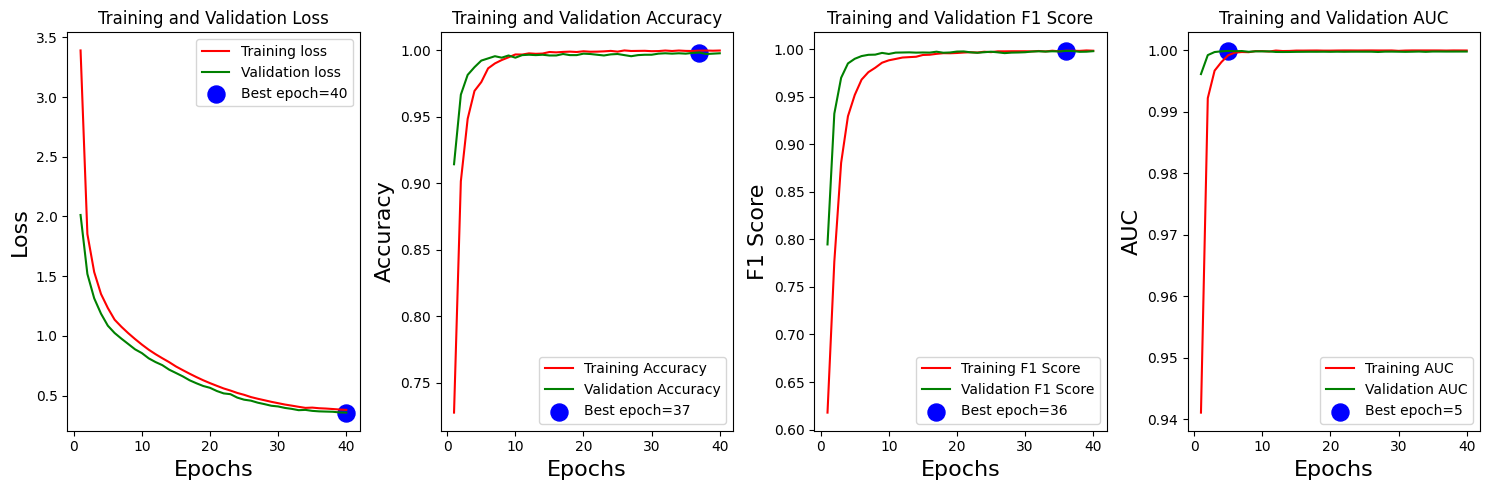

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def tr_plot(tr_data):
    start_epoch = 0

    # Lấy dữ liệu từ lịch sử huấn luyện
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    tf1 = tr_data.history['f1_score']
    vf1 = tr_data.history['val_f1_score']
    tauc = tr_data.history['auc']
    vauc = tr_data.history['val_auc']

    # Tính toán số epoch
    Epoch_count = len(tacc) + start_epoch
    Epochs = list(range(start_epoch + 1, Epoch_count + 1))

    # Tìm chỉ số quan trọng
    index_loss = np.argmin(vloss)  # Epoch với validation loss thấp nhất
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)  # Epoch với validation accuracy cao nhất
    acc_highest = vacc[index_acc]
    auc_index = np.argmax(vauc)  # Epoch với validation AUC cao nhất
    val_highest_auc = vauc[auc_index]

    # Tùy chỉnh giao diện
    plt.style.use('default')  # Chuyển sang nền trắng
    fig_height = 10  # Chiều cao cũ
    adjusted_height = fig_height * 0.5  # Giảm 10%

    # Tạo biểu đồ với 4 subplots
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, adjusted_height))

    # Biểu đồ 1: Loss
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1, val_lowest, s=150, c='blue', label=f'Best epoch={index_loss + 1}')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=16)
    axes[0].set_ylabel('Loss', fontsize=16)
    axes[0].legend()

    # Biểu đồ 2: Accuracy
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1, acc_highest, s=150, c='blue', label=f'Best epoch={index_acc + 1}')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=16)
    axes[1].set_ylabel('Accuracy', fontsize=16)
    axes[1].legend()

    # Biểu đồ 3: F1 Score
    axes[2].plot(Epochs, tf1, 'r', label='Training F1 Score')
    axes[2].plot(Epochs, vf1, 'g', label='Validation F1 Score')
    axes[2].scatter(np.argmax(vf1) + 1, max(vf1), s=150, c='blue', label=f'Best epoch={np.argmax(vf1) + 1}')
    axes[2].set_title('Training and Validation F1 Score')
    axes[2].set_xlabel('Epochs', fontsize=16)
    axes[2].set_ylabel('F1 Score', fontsize=16)
    axes[2].legend()

    # Biểu đồ 4: AUC
    axes[3].plot(Epochs, tauc, 'r', label='Training AUC')
    axes[3].plot(Epochs, vauc, 'g', label='Validation AUC')
    axes[3].scatter(auc_index + 1, val_highest_auc, s=150, c='blue', label=f'Best epoch={auc_index + 1}')
    axes[3].set_title('Training and Validation AUC')
    axes[3].set_xlabel('Epochs', fontsize=16)
    axes[3].set_ylabel('AUC', fontsize=16)
    axes[3].legend()

    # Tăng khoảng cách giữa các biểu đồ và hiển thị
    plt.tight_layout()
    plt.show()
tr_plot(history)

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):

    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=18)

    # Label the axes
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()


In [1]:
!pip install scikit-learn
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.preprocessing import label_binarize  # Import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, confusion_matrix, classification_report

In [2]:
def predictor(test_gen):
    y_pred = []
    error_list = []
    error_pred_list = []
    y_true = test_gen.labels
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0

    preds = model.predict(test_gen, verbose=1)
    tests = len(preds)

    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = test_gen.labels[i]
        if pred_index != true_index:  # Misclassification
            errors += 1
            file = test_gen.filenames[i]
            error_list.append(file)
            error_class = classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)

    # Accuracy
    acc = (1 - errors / tests) * 100
    print(f'There were {errors} errors in {tests} tests for an accuracy of {acc:.2f}%')

    # Convert predictions and true labels to numpy arrays
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    # F1-Score
    f1score = f1_score(y_true, y_pred, average='weighted') * 100
    print(f'F1-Score: {f1score:.2f}%')

    # Confusion Matrix
    if class_count <= 80:
        cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, classes, figsize=(12, 10))

    # Classification Report
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n", clr)

    auc_scores = []
    # Multi-class ROC-AUC or Binary ROC-AUC
    if class_count == 2:  # Binary classification
        y_true_bin = label_binarize(y_true, classes=[0, 1])
        y_proba = preds[:, 1]  # Probability of the positive class

        fpr, tpr, _ = roc_curve(y_true_bin, y_proba)
        auc_score = roc_auc_score(y_true_bin, y_proba)

        plt.figure(figsize=(12, 8))
        plt.plot(fpr, tpr, label=f'Binary ROC (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('AUC-ROC Curve for Binary Classification', fontsize=16)
        plt.legend(fontsize=14)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid(True)
        plt.show()

        print(f'Binary AUC: {auc_score:.4f}')
    else:  # Multi-class classification
        y_true_bin = label_binarize(y_true, classes=np.arange(class_count))
        y_proba = preds  # Use predicted probabilities

        plt.figure(figsize=(12, 8))


        for i in range(class_count):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
            auc_score = roc_auc_score(y_true_bin[:, i], y_proba[:, i])
            auc_scores.append(auc_score)
            plt.plot(fpr, tpr, label=f'Class {classes[i]} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('AUC-ROC Curve for Each Class', fontsize=18)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
    plt.tight_layout()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.show()

    for i, auc in enumerate(auc_scores):
        print(f'AUC for {classes[i]}: {auc:.4f}')

# return errors, tests, error_list, error_pred_list, f1score, y_true, y_pred, preds    return errors, tests, error_list, error_pred_list, f1score
    return errors, tests, error_list, error_pred_list, f1score, y_true, y_pred, preds

# Gọi hàm
errors, tests, error_list, error_pred_list, f1score, y_true, y_pred, y_proba = predictor(test_gen)

NameError: name 'test_gen' is not defined

In [ ]:
test_images = [f for f in os.listdir('/content/aug/Tomato___Late_blight')]
dataset = np.ndarray(shape=(len(test_images), 200, 200, 3))

import cv2

for i, file_name in enumerate(test_images):
  try:
    img=cv2.imread('/content/aug/Tomato___Late_blight' + file_name)
    img_resize=cv2.resize(img,(200,200))
    dataset[i]=np.array(img_resize)/255.0
  except:
    print(file_name)
dataset.shape